## Imports

In [1]:
import bertFuncs as func
from functions import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics.pairwise import cosine_similarity
from transformers import logging
logging.set_verbosity_error()
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict
from nltk.corpus import wordnet as wn

## 1. Get Embeddings

### 1.1 Get Firm Embeddings

In [4]:
# Read S&P500 company names.
# Source: https://github.com/datasets/s-and-p-500-companies/blob/master/data/constituents.csv

company_names = pd.read_csv("sp500.csv")
company_names["Count"] = company_names['Name'].str.split().apply(len)

In [5]:
company_names

,Symbol,Name,Sector,Count
0,MMM,3M,Industrials,1
1,AOS,A. O. Smith,Industrials,3
2,ABT,Abbott Laboratories,Health Care,2
3,ABBV,AbbVie,Health Care,1
4,ABMD,Abiomed,Health Care,1
...,...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary,2
501,ZBRA,Zebra Technologies,Information Technology,2
502,ZBH,Zimmer Biomet,Health Care,2
503,ZION,Zions Bancorp,Financials,2


In [7]:
# Get embeddings for S&P 500 names. Average embeddings are calculated for multi-word firms. 
# Stored for faster import later. 


context = "works"

for company in tqdm(company_names['Name']):
    name_list = company.split(" ")
    
    # Get contextual embedding for each part of the name.  
    embeddings = pd.DataFrame()
    for name in name_list: 
        embeddings[[f"{name}_male", f"{name}_female", "tuple"]] = get_firm_embeddings(name, context, 58, "all")[["Value 1", "Value 2", "tuple"]]
    
    # Take average of different name parts. 
    embeddings["average_male"] = embeddings.loc[:, embeddings.columns.str.endswith('_male')].mean(axis=1)
    embeddings["average_female"] = embeddings.loc[:, embeddings.columns.str.endswith('_female')].mean(axis=1)
    
    # Calculate delta / bias. 
    embeddings["female-male"] = embeddings["average_female"] - embeddings["average_male"]
    
    # Store for faster import later. 
    embeddings.to_csv(f"./averaged_embeddings/{company}.csv")

  0%|          | 0/505 [00:00<?, ?it/s]

### 1.1 Get Random Noun Embeddings

In [8]:
# Load and clean list of english nouns and generate random sample. 

nouns = pd.read_csv('nouns.csv', sep=";")
nouns = nouns[nouns['nouns'].str.strip().str.split(' ').str.len().eq(1)] # Only considering single word nouns.
nouns_sample = nouns["nouns"].sample(n = 500, random_state = 42)

nouns_sample = list(nouns_sample)

In [9]:
# Need to make sure no company names in random nouns
nouns_sample.remove("ford")

In [10]:
# Get embeddings for random nouns. 
# Stored for faster import later. 



context = "works"

for noun in tqdm(nouns_sample):
    comparison = get_firm_embeddings(noun, context, 58, "all")
    comparison.to_csv(f"./averaged_embeddings/{noun}.csv")

  0%|          | 0/499 [00:00<?, ?it/s]

## 2. Initial analysis

In [11]:
# Get all considered dimensions. 

dimensions = get_firm_embeddings("amazon", "works", 58, "all")
all_dimensions = dimensions["tuple"].unique()

### 2.1 Distribution Plots

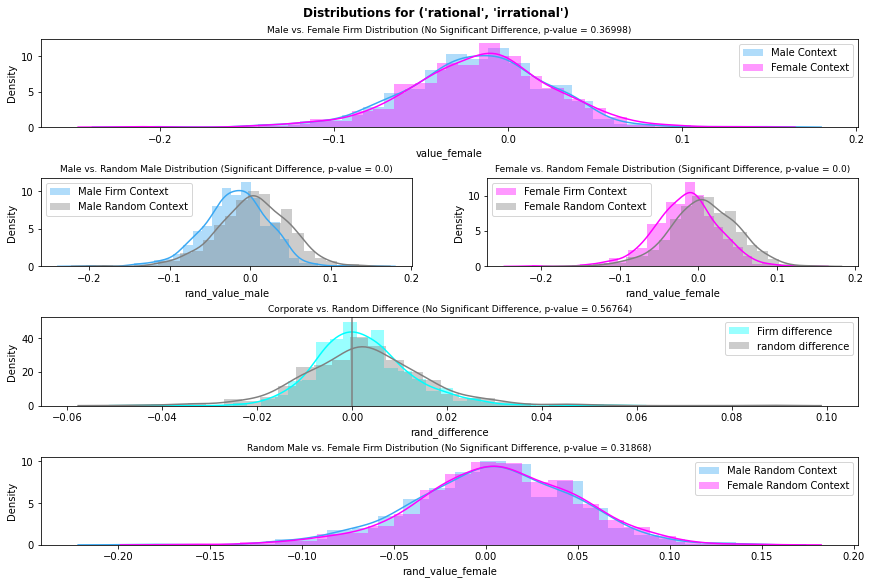

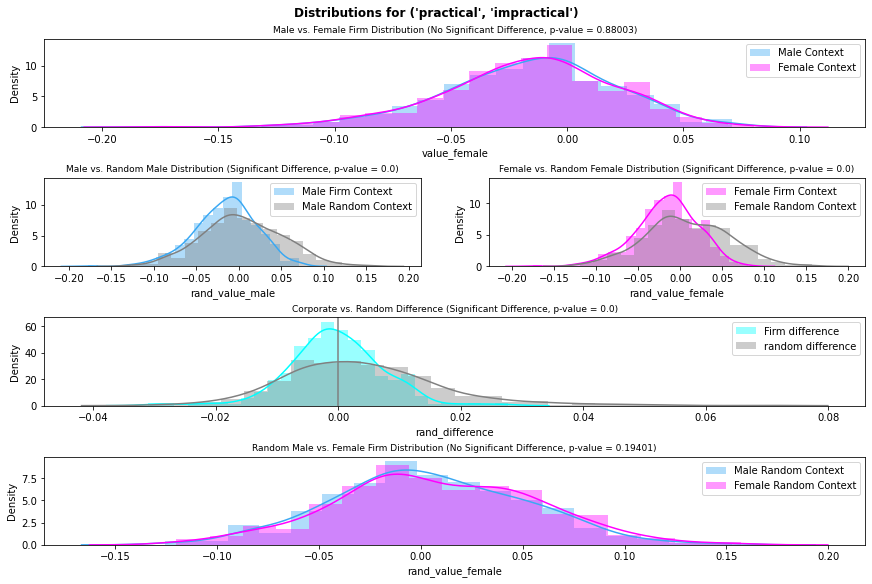

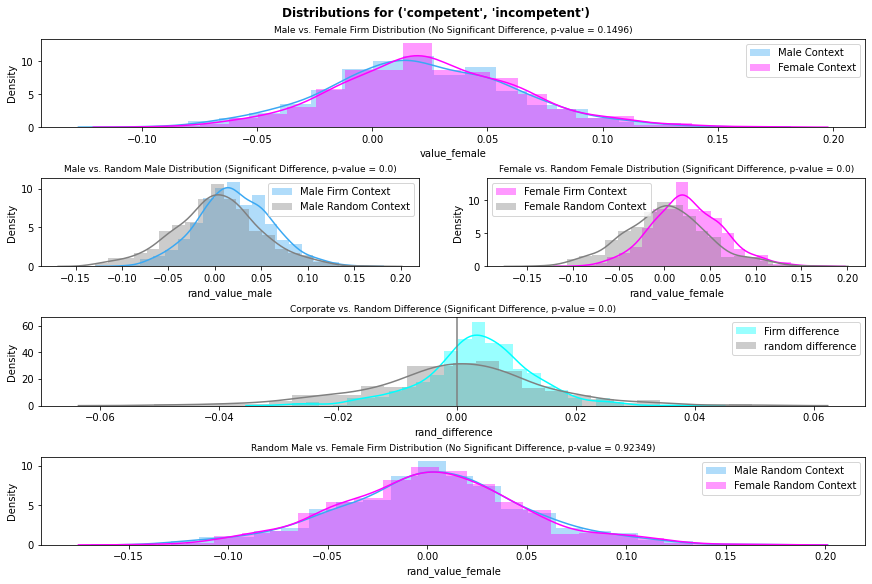

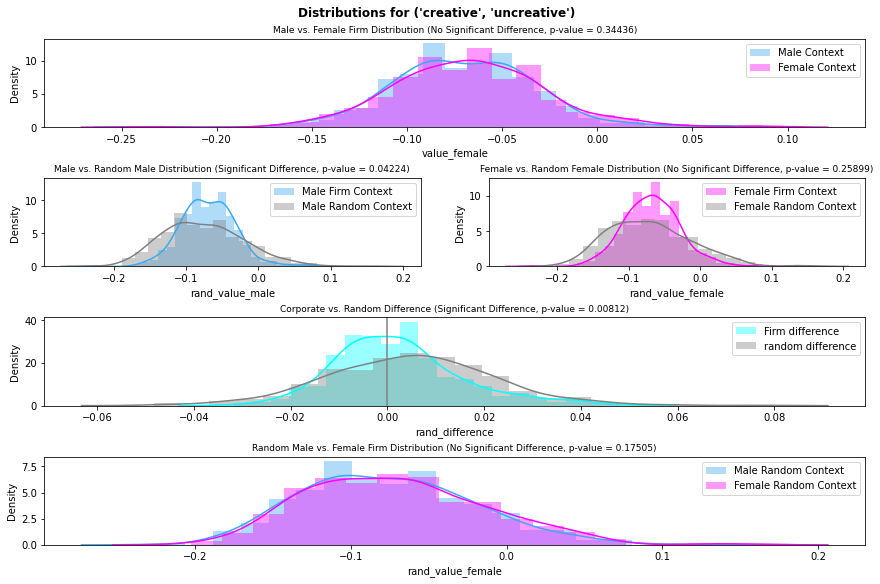

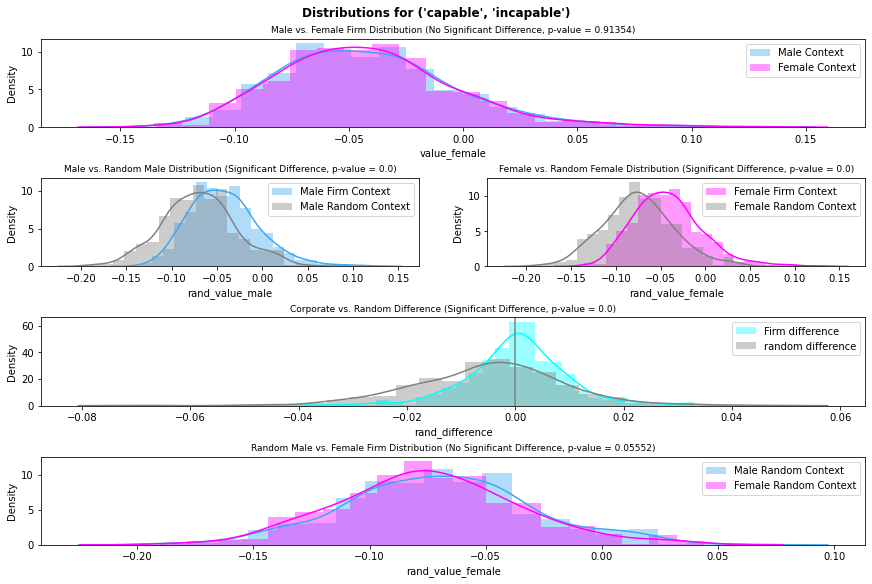

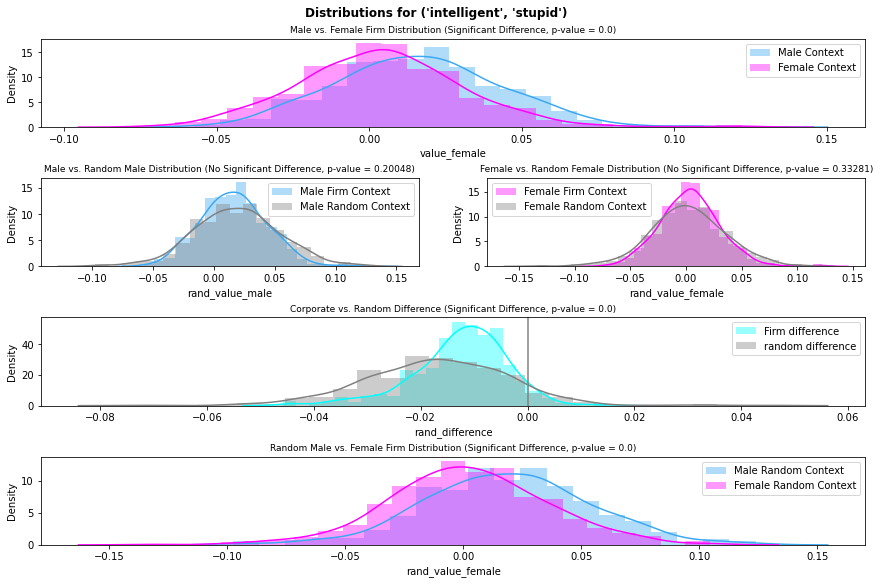

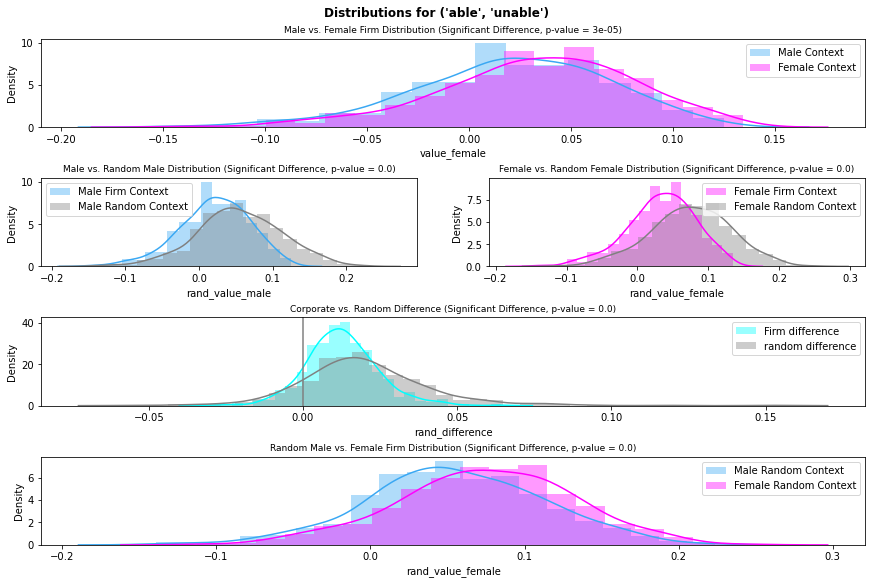

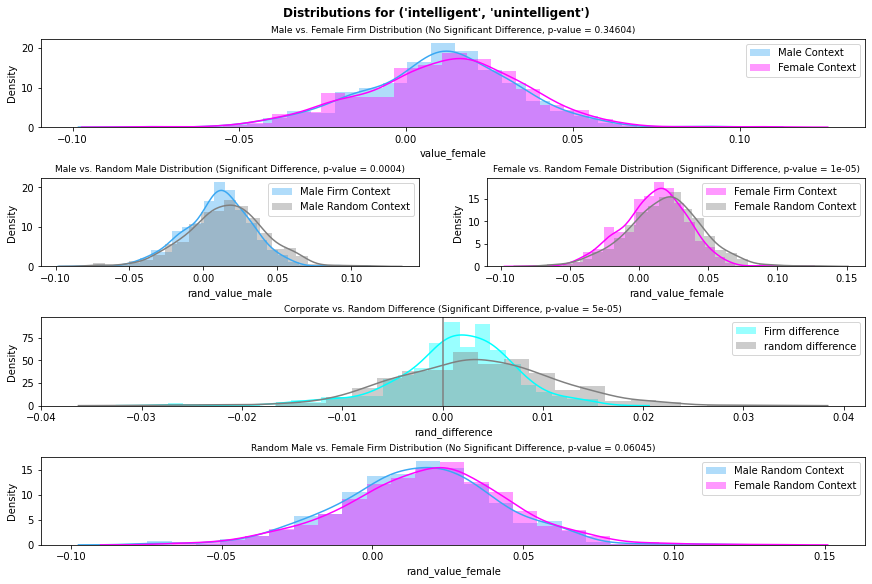

In [6]:
# Create plots for all 8 dimensions. 

for dimension in all_dimensions: 
    get_dimension_distribution(company_names["Name"], str(dimension), nouns_sample)

### 2.2 P-Values

In [15]:
considered_companies = company_names["Name"].unique()

In [16]:
# also tested for single-word company names 
#considered_companies = company_names[company_names["Count"] == 1]["Name"]


res_all = defaultdict()

for dimension in tqdm(all_dimensions): 
    res = get_dimension_pvalues(considered_companies, str(dimension), nouns_sample)
    res_all[dimension] = res
    
res_all_df = pd.DataFrame(res_all).transpose()
res_all_df.rename(columns = {0:"Male vs. Female Corporate Embedding", 1:"Male Firm vs. Male Random", 
                         2:"Female Firm vs. Female Random", 3:"Difference Firm vs. Difference Random",
                        4:"Male vs. Female Random Embedding"}, 
              inplace = True)

  0%|          | 0/56 [00:00<?, ?it/s]

In [17]:
res_all_df

,,Male vs. Female Corporate Embedding,Male Firm vs. Male Random,Female Firm vs. Female Random,Difference Firm vs. Difference Random,Male vs. Female Random Embedding
creative,uncreative,0.44179,0.00000,0.00000,0.20987,0.70763
friendly,unfriendly,0.04067,0.07424,0.05336,0.64803,0.05581
liked,disliked,0.89506,0.00000,0.00000,0.72010,0.96231
rich,poor,0.32793,0.00000,0.00000,0.00000,0.14446
unprejudiced,prejudiced,0.00627,0.00000,0.00000,0.00317,0.05610
reliable,unreliable,0.21684,0.00000,0.00001,0.00837,0.15405
conventional,unconventional,0.00000,0.13824,0.00487,0.00004,0.00000
smart,stupid,0.81871,0.00000,0.00000,0.01427,0.57026
conservative,liberal,0.67086,0.00000,0.00000,0.00018,0.44506
superior,inferior,0.00052,0.02274,0.03529,0.41853,0.00285


In [25]:
sign_level = 0.05

res_all_df_filtered = res_all_df.loc[
                    (res_all_df["Male vs. Female Corporate Embedding"] < sign_level) 
                    #& (res_all_df["Male Firm vs. Male Random"] < sign_level) 
                    #& (res_all_df["Female Firm vs. Female Random"] < sign_level) 
                    & (res_all_df["Difference Firm vs. Difference Random"] < sign_level) 
                    #& (res_all_df["Male vs. Female Random Embedding"] < sign_level) 
                    ]

In [26]:
len(res_all_df_filtered)

22

In [8]:
dimensions_df = pd.DataFrame(all_dimensions)
dimensions_df["average"] = 0

for dimension in tqdm(all_dimensions): 
    
    company_res = []
    
    for company in considered_companies: 
        comparison = pd.read_csv(f"./averaged_embeddings/{company}.csv")
        company_res.append(float(comparison[comparison["tuple"] == str(dimension)]["female-male"]))
        
    dimensions_df["average"].loc[dimensions_df[0] == dimension] = (sum(company_res) / len(company_res))*100

  0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
dimensions_df

,0,average
0,"(rational, irrational)",0.231156
1,"(practical, impractical)",-0.035110
2,"(competent, incompetent)",0.355511
3,"(creative, uncreative)",0.230125
4,"(capable, incapable)",0.026343
5,"(intelligent, stupid)",-1.248136
6,"(able, unable)",1.262276
7,"(intelligent, unintelligent)",0.137636


In [61]:
comparison = pd.read_csv(f"./averaged_embeddings/Bank of America.csv", index_col = 0)

In [62]:
round((comparison["female-male"].mean())*100000, 5)

104.7534

### 2.3 Average over all dimensions

In [13]:
# Get delta for selected antonyms between male and female vector. 

company_names["Selected_Mean_Delta"] = 0

for name in tqdm(company_names["Name"].unique()):
    comparison = pd.read_csv(f"./averaged_embeddings/{name}.csv")
    company_names["Selected_Mean_Delta"].loc[company_names["Name"] == name] = (comparison["female-male"].mean())*10000

  0%|          | 0/505 [00:00<?, ?it/s]

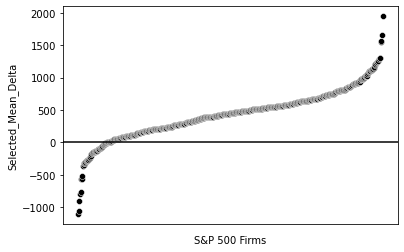

In [14]:
# Plot difference between selected dimensions for firms. 

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

g1 = sns.scatterplot(data = company_names.sort_values(by=["Selected_Mean_Delta"], ascending=True), x = "Name", y = "Selected_Mean_Delta", color = "black", ax = ax)
g1.set(xticklabels=[]) 
g1.set(xlabel="S&P 500 Firms") 
g1.axhline(0, color = "black")
g1.tick_params(bottom=False)  

In [77]:
len(company_names[company_names["Selected_Mean_Delta"] > 50])/len(company_names)

0.041584158415841586

In [69]:
company_names[company_names["Selected_Mean_Delta"] == company_names["Selected_Mean_Delta"].max()]

,Symbol,Name,Sector,Count,Selected_Mean_Delta
98,CDAY,Ceridian,Information Technology,1,100.797355


<AxesSubplot:xlabel='Selected_Mean_Delta', ylabel='Density'>

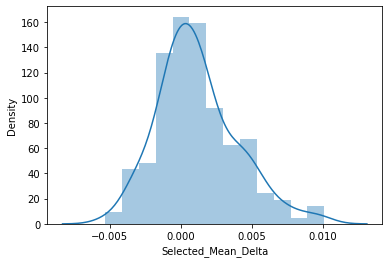

In [11]:
sns.distplot(company_names[company_names["Count"] == 1]["Selected_Mean_Delta"])

In [31]:
# Analyze companies with highest difference meaning highest bias toward female embedding. 

company_names.sort_values(by=["Selected_Mean_Delta"], ascending=False).head(10).reset_index(drop = True)

,Symbol,Name,Sector,Selected_Mean_Delta
0,CDAY,Ceridian,Information Technology,0.010080
1,TRMB,Trimble,Information Technology,0.009339
2,NI,NiSource,Utilities,0.009261
3,LIN,Linde,Materials,0.008017
4,QRVO,Qorvo,Information Technology,0.007636
5,GRMN,Garmin,Consumer Discretionary,0.007536
6,VRTX,Vertex Pharmaceuticals,Health Care,0.007145
7,FTV,Fortive,Industrials,0.006906
8,DVN,Devon Energy,Energy,0.006762
9,CI,Cigna,Health Care,0.006610


<AxesSubplot:xlabel='Selected_Mean_Delta', ylabel='Sector'>

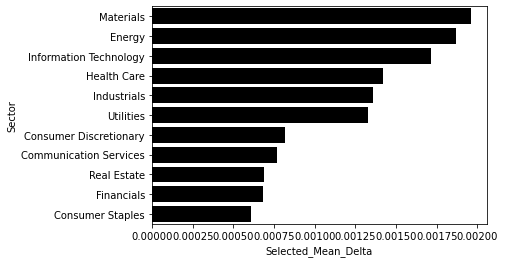

In [12]:
# Check for difference between sectors. 

sp_500_groupedby_industry = company_names.groupby("Sector").mean().sort_values(by=["Selected_Mean_Delta"], 
                                                                        ascending=False)
sns.barplot(data = sp_500_groupedby_industry, y = sp_500_groupedby_industry.index, 
            x= "Selected_Mean_Delta", color = "black")